# Computer  Vision Capstone - Image Classification (Part 2)

Author: Diana Rogachova

Welcome to this second notebook on Image Classification. We will utilize TensorFlow platform and Keras library to apply Convolutional Neural Networks (CNNs) on our classification task. Mention that in the previous notebook we utilized Scikit-Learn to use various models, most of which demonstrated good performance, providing 100% or near 100% accuracy on both binary and multi-class classification. While we are happy with the results of these models, we will experiment with CNNs to further develop our understanding of this algorithm and its application in image classification.  

#### Binary Classification

Due to the oraganization of our dataset we need to split split our folders in order to load in the data correctly. The code to split folders was taken from this: [Source](https://medium.com/nerd-for-tech/easily-split-your-directory-into-train-validation-and-testing-format-f1359f34dd93).   

In [80]:
# Instanling dependencies to split my train folder
!conda install splitfolders

python(10588) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Retrieving notices: ...working... done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - splitfolders

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-arm64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/osx-arm64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/osx-arm64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://conda.anaconda.org/conda-forge/osx-arm64
  - https://conda.anaconda.org/conda-forge/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [104]:
import splitfolders

splitfolders.ratio("Train Images Binary/Original", # train folder containing my two classes
                   output="Train images", # place when new subfolders will be created
                   seed=42,
                   ratio=(.7, .3), # spliting 70% for train and 30% for validation
                   group_prefix=None,
                   move=False
                   )

Copying files: 1230 files [00:00, 2769.61 files/s]


Now that our images are in correct format for loading them in, we will also perform some image augmentation as we upload them. The code to rescale images was taken from this: [Source](https://www.youtube.com/watch?v=ccdssX4rIh8). 

### Loading libraries

In [105]:
# Import base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Importing random seed for reproducibility and importing layers for the model
import random

# Importing the libraries for tensorflow
import tensorflow as tf
# Imprting image generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Importing the libraries for the model and layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation 
# Early stopping
from tensorflow.keras.callbacks import EarlyStopping

# ResNet50V2 architecture
from tensorflow.keras.applications import ResNet50V2

# import the library for loading images 
from keras.preprocessing import image

### Data Loading and Image Augmentation 

As we have seen before, image augmentation can help us with increasing the size of our data and introduce diversity to it which in turn may help when we present model with unseen data because it has seen data in many different contexts such as different exposure, shade, contast and so on. In other words, augmentation makes the model more generalizable. 

For this first step, we are going to load our data and then perform data augmentation as the images are being uploaded. It is important to note that Convolutional Neural Networks can learn features that are invariant to their location on the image [Source](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/). That being said, "augmentation can further aid the model in learning features that are also invariant to transforms such as left-to-right to top-to-bottom ordering, light levels and so on" [Source](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/). In contrast to data augmentation we performed with Scikit-image where we created copies of our data, here we apply data augmentation with use of Keras library, which will only apply preprocessing layers on the data without increasing its size.   

In [106]:
# Selecting hight, width and indicating that these are collored images
height = 100
width = 100
channels = 3

train_datagen = ImageDataGenerator(rescale=1./255, # augmenting and rescaling train set
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255) # only rescalling validation set

train_generator=train_datagen.flow_from_directory('Train Images/train/', # source folder
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 seed=123)

validation_generator=validation_datagen.flow_from_directory('Train Images/val/', # source folder
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                               seed=123)

Found 860 images belonging to 2 classes.
Found 370 images belonging to 2 classes.


Now that we have uploaded our images we have **860** training images and **370** validation images. Next we will introduce the ResNet50 architecture. 

### ResNet-50 

In general, these are two broad ways to perform tasks using neural networks. One is to train the model from strach, that use your own data to train all the layers and let the model learn all the wights from this data. Second, is to use a pre-trained model, that is a model that was trained on a large amount of data and learned a lot of weights from that data, and apply these learned weights on our data to make predictions. In our case we will use the latter. The architecture we will be using is call [ResNet-50](https://www.mathworks.com/help/deeplearning/ref/resnet50.html). ResNet-50 is a CNN architecture that was trained on more than a million of ImageNet images. As the name suggests, ResNet-50 is 50 convolutional layers deep. 

In [107]:
# Employing pre-trained ResNet50V2 model
res_model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels)) # importing weights and freezing the top layer
res_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 52, 52, 64)   0           ['conv1_conv[0][0]']    

In [108]:
# Freezing all layers to train only the top layer
for layer in res_model.layers:
    layer.trainable = False

In [109]:
# add layers to the pre-trained model
resnet = res_model.output
resnet = Flatten()(resnet) # adding a flatten layer
resnet = Dense(32, activation='relu')(resnet) # adding a dense layer
resnet = Dense(32, activation='relu')(resnet) # adding a dense layer
resnet = Dropout(0.5)(resnet) # adding a dropout layer
output = Dense(2, activation='sigmoid')(resnet) # the last layer is 2 because the task is binary classification

model = Model(inputs=res_model.input,
                outputs=output) # creating the model


### Training the Model

In [111]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) # compiling the model

# Early stoping to stop the training when there is no improvement in loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1) # verbose to see the output
model.fit(train_generator,
          epochs=20,
          validation_data = validation_generator)

Epoch 1/20
27/27 [==============================] - 9s 321ms/step - loss: 0.4834 - accuracy: 0.8477 - val_loss: 0.0598 - val_accuracy: 0.9946
Epoch 2/20
27/27 [==============================] - 8s 304ms/step - loss: 0.2158 - accuracy: 0.9419 - val_loss: 0.0085 - val_accuracy: 0.9973
Epoch 3/20
27/27 [==============================] - 8s 302ms/step - loss: 0.1278 - accuracy: 0.9640 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 4/20
27/27 [==============================] - 9s 334ms/step - loss: 0.0907 - accuracy: 0.9733 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/20
27/27 [==============================] - 9s 342ms/step - loss: 0.0651 - accuracy: 0.9744 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/20
27/27 [==============================] - 9s 320ms/step - loss: 0.0520 - accuracy: 0.9814 - val_loss: 1.0002e-04 - val_accuracy: 1.0000
Epoch 7/20
27/27 [==============================] - 9s 344ms/step - loss: 0.0610 - accuracy: 0.9895 - val_loss: 2.5139e-05 - val_accuracy: 1.000

<Axes: >

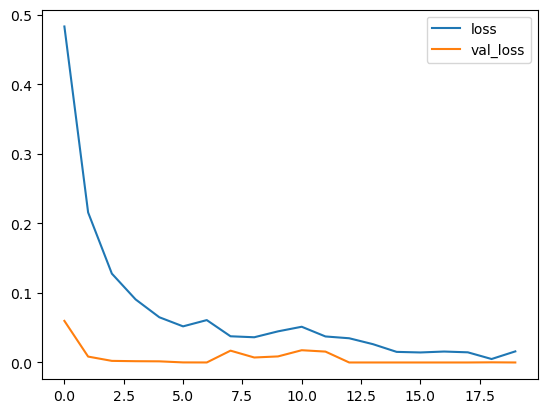

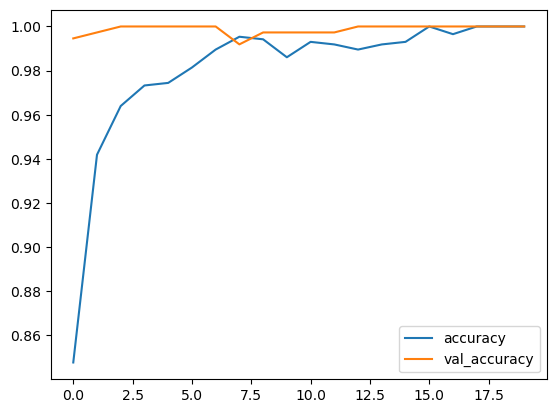

In [112]:
# ploting the loss and accuracy over the epochs
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()

We see from the graphs above that both loss and accuracy improved with each epoch. We see small improvement in accuracy after about 6-7 epochs, therefore, next time we will add early stopping to stop training when there no more improvement in accuracy.  

### Testing the Model

Now that we have used ResNet50's pretrained weights and added the weights from our fruit data to the last layer, we will test how our model is doing on new data. Let's load our test images. 

In [113]:
test_datagen = ImageDataGenerator(rescale=1./255) # load test images and scale them
test_generator = test_datagen.flow_from_directory('Test Images Binary/',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=322,
                                                  class_mode='categorical',
                                                  seed=123)

X_test, y_test = test_generator.next()

Found 410 images belonging to 2 classes.


In [114]:
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

11/11 [==============================] - 2s 188ms/step - loss: 3.8347e-10 - accuracy: 1.0000
Test loss: 3.8346906205966036e-10
Test accuracy: 1.0


The accuracy of the test set is comparable to what we observed on validation set and remains very high. Next, we will create a confusion matrix to evaluate the model probabilities (compiled probabilities showing how well the model classified/predicted each class). 

In [115]:
# predictions
predict_probas = model.predict(X_test)

# Convering probabilities into label encoding
y_predict = np.argmax(predict_probas, axis=1)

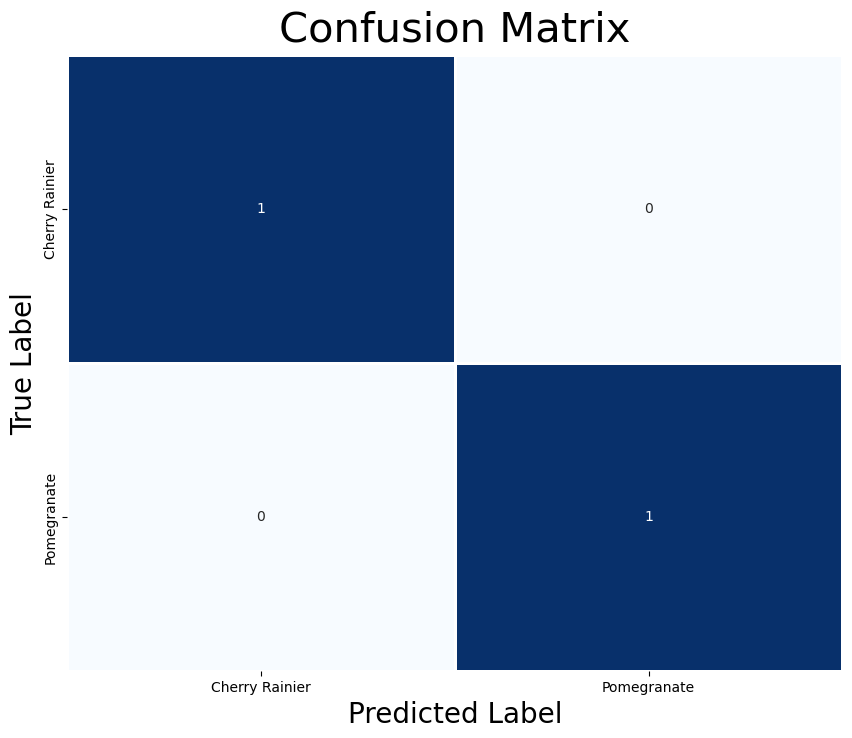

In [116]:
fruit_labels = ['Cherry Rainier',
                'Pomegranate']

y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (10,8))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels=fruit_labels,
            yticklabels=fruit_labels,
            cmap="Blues",
            linewidths=1,

           )
plt.title('Confusion Matrix',size = 30,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

The model gave a perfect accuracy for the binary classification task! Let's see if we can generate any predictions. 
 

In [117]:
# load image and get prediction
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(height, width))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    predict_probas = model.predict(img_tensor)
    y_predict = np.argmax(predict_probas, axis=1)

    if y_predict == 0:
        print('Cherry Rainier')
    else:
        print('Pomegranate')

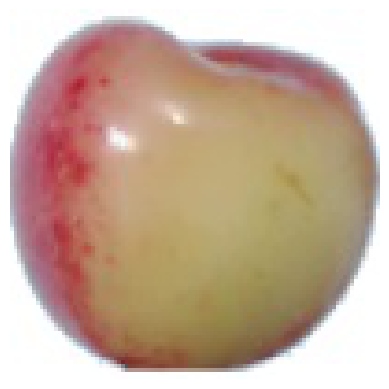

Cherry Rainier


In [118]:
# Predicting a fruit
predict_image('Test Images Binary/Cherry Rainier/69_100.jpg')

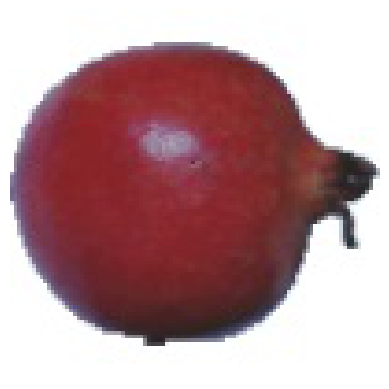

Pomegranate


In [119]:
predict_image('Test Images Binary/Pomegranate/r_303_100.jpg')

It looks like our model is working well and generating correct predictions. Next, we will repeat the exact steps but with multi-class classification task. 

## Multi-Class Classification

### Data Preprocessing: Image Augmentation

In [120]:
# Selecting hight, width and indicating that these are collored images
height = 100
width = 100
channels = 3

train_datagen = ImageDataGenerator(rescale=1./255, # augmenting and rescaling train set
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='reflect')

validation_datagen = ImageDataGenerator(rescale=1./255) # only rescalling validation set

train_generator=train_datagen.flow_from_directory('Train Images Multi/train/', # source folder
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 seed=123)

validation_generator=validation_datagen.flow_from_directory('Train Images Multi/val/', # source folder
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                               seed=123)

Found 1759 images belonging to 4 classes.
Found 442 images belonging to 4 classes.


### Training the Model

In [121]:
# Employing pre-trained ResNet50V2 model
res_model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels)) # importing weights and freezing the top layer

In [122]:
# Freezing all layers to train only the layers we add
for layer in res_model.layers:
    layer.trainable = False

In [124]:
# Adding layers
resnet = res_model.output
resnet = Flatten()(resnet) # adding a flatten layer
resnet = Dense(32, activation='relu')(resnet)
resnet = Dense(32, activation='relu')(resnet)
resnet = Dropout(0.5)(resnet)
output = Dense(4, activation='softmax')(resnet) # the last layer is 4 because the task is multi-class classification

model = Model(inputs=res_model.input,
                outputs=output)

In [125]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)
model.fit(train_generator,
          epochs=20,
          validation_data = validation_generator,
          callbacks=[early_stop])

Epoch 1/20
55/55 [==============================] - 16s 258ms/step - loss: 1.0134 - accuracy: 0.7288 - val_loss: 0.0363 - val_accuracy: 0.9932
Epoch 2/20
55/55 [==============================] - 15s 268ms/step - loss: 0.3133 - accuracy: 0.8926 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 3/20
55/55 [==============================] - 14s 255ms/step - loss: 0.1923 - accuracy: 0.9403 - val_loss: 0.0166 - val_accuracy: 0.9955
Epoch 4/20
55/55 [==============================] - 14s 256ms/step - loss: 0.1512 - accuracy: 0.9517 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/20
55/55 [==============================] - 14s 250ms/step - loss: 0.1271 - accuracy: 0.9642 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/20
55/55 [==============================] - 14s 253ms/step - loss: 0.0992 - accuracy: 0.9670 - val_loss: 0.0076 - val_accuracy: 0.9977
Epoch 00006: early stopping


<Axes: >

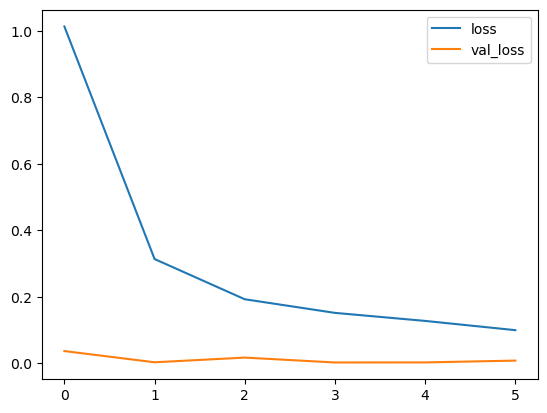

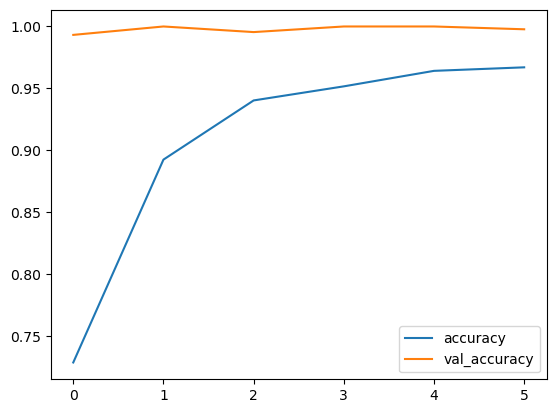

In [126]:
# ploting the loss and accuracy over the epochs
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()

Similarly to the binary classification, the multi-class classification also showed a very high accuracy only after several epochs. 

In [127]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('Test Images Multi/',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=734,
                                                  class_mode='categorical',
                                                  seed=123)

X_test2, y_test2 = test_generator.next()

Found 734 images belonging to 4 classes.


### Testing the Model

In [128]:
score = model.evaluate(X_test2, y_test2, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

23/23 [==============================] - 5s 199ms/step - loss: 0.0630 - accuracy: 0.9768
Test loss: 0.06304039061069489
Test accuracy: 0.9768392443656921


The test set demostrated similar accuracy to the test set in this classification task. Next, we will create a confusion matrix to see which the model's performance with different classes. 

In [129]:
import numpy as np
predict_probas2 = model.predict(X_test2)

y_predict2 = np.argmax(predict_probas2, axis=1)

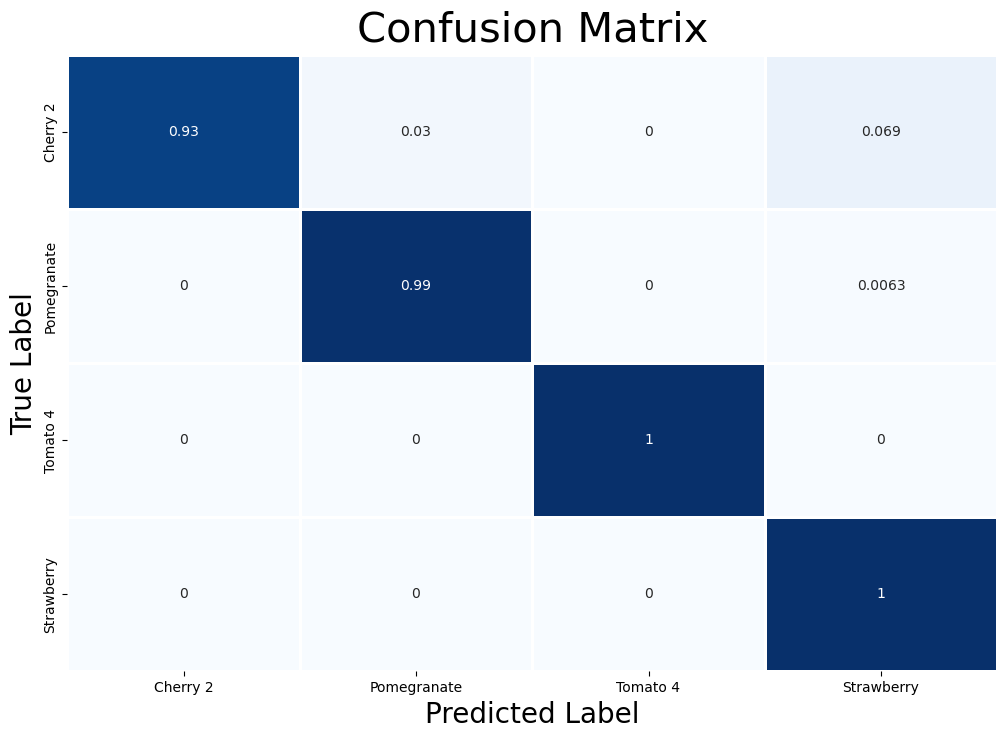

In [130]:
fruit2_labels = ['Cherry 2',
                'Pomegranate',
                'Tomato 4',
                'Strawberry']

y_test2_labels = np.argmax(y_test2, axis=1)

conf_mat = confusion_matrix(y_test2_labels, y_predict2)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (12,8))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels=fruit2_labels,
            yticklabels=fruit2_labels,
            cmap="Blues",
            linewidths=1,

           )
plt.title('Confusion Matrix',size = 30,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

The model performed very well and showed 97% accuracy on multi-class classification task. There are a few misclassifications between Cherry, Pomegranate and Strawberry classes, likely due to high similarity between these fruit images. However, we consider these to be good results. 

In [131]:
# load image and get prediction
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(height, width))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    predict_probas2 = model.predict(img_tensor)
    y_predict2 = np.argmax(predict_probas2, axis=1)

    if y_predict2 == 0:
        print('Cherry 2')
    elif y_predict2 == 1:
        print('Pomegranate')
    elif y_predict2 == 2:
        print('Strawberry')
    else:
        print('Tomato 4')

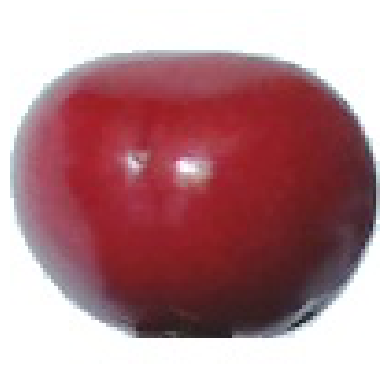

Cherry 2


In [132]:
# Predicting a cherry
predict_image('Test Images Multi/Cherry 2/r_58_100.jpg')

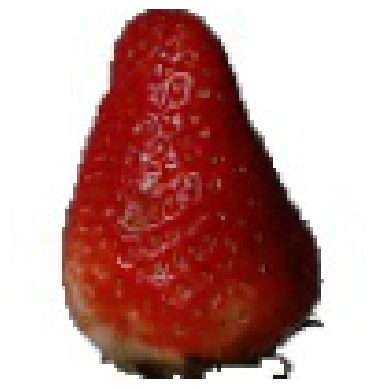

Strawberry


In [133]:
# predicting a pomegranate
predict_image('Test Images Multi/Strawberry/46_100.jpg')

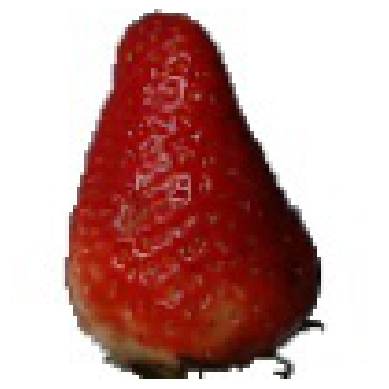

Strawberry


In [56]:
# predicting a tomato
predict_image('Test Images Multi/Strawberry/50_100.jpg')

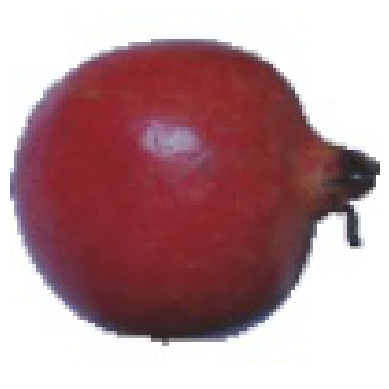

Pomegranate


In [57]:
# predicting a strawberry
predict_image('Test Images Multi/Pomegranate/r_6_100.jpg')

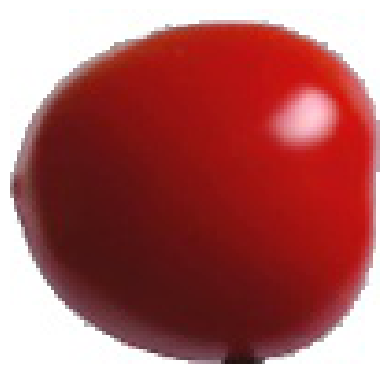

Tomato 4


In [58]:
# predicting a fruit
predict_image('Test Images Multi/Tomato 4/r_296_100.jpg')

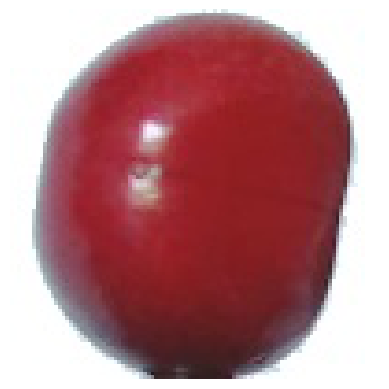

Cherry 2


In [59]:
# predicting a fruit
predict_image('Test Images Multi/Cherry 2/r2_295_100.jpg')

Based on these predictions, we conclude that the model is genrating correct predictions for our fruit classes. This section will conclude our project. 

## Conclusion

This notebook pressented the last portion of our project on image classification using various models including Convolutional Neural Networks. Our next steps will be training an object detection machine to identify images of multiple different fruit on image. 